In [7]:
import pandas as pd 
import numpy as np 
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from scipy.stats import uniform

In [8]:
raw_train = pd.read_csv('train.csv')

In [71]:
def convert_cat(df, cat_features):
    encoder = LabelEncoder()
    for feature in cat_features:
        df[feature] = encoder.fit_transform(df[feature])
    return df    

In [69]:
def make_submission(df_test, model):
    y_hat_test = model.predict(df_test)
    df_final = pd.DataFrame({
        df_test.columns[0]: df_test.iloc[:, 0],  
        "Transported": y_hat_test.astype(bool)   
    })
    return df_final

### Let's split 'Cabin' column into 3 separate columns 

In [70]:
def preprocess_df(df, train):
    train_mod = df
    train_mod[['CabinDeck', 'CabinNum', 'CabinSide']] = train_mod['Cabin'].str.split('/', expand=True)
    train_mod['CabinNum'] = pd.to_numeric(train_mod['CabinNum'], errors='coerce')

    if train: 
        cat_features = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'Transported', 'CabinDeck', 'CabinSide']
    else:
        cat_features = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'CabinDeck', 'CabinSide']
    for feature in cat_features:
        train_mod[feature] = train_mod[feature].astype('category')
    train_mod = train_mod.drop('Cabin', axis=1)
    
    return train_mod

In [11]:
raw_train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

train_mod.isna().sum()

train_mod.dtypes

In [33]:
train_mod = preprocess_df(raw_train, True)
train_mod

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,CabinDeck,CabinNum,CabinSide
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98.0,P
8689,9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499.0,S
8690,9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500.0,S
8691,9280_01,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608.0,S


In [13]:
train_mod.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
CabinDeck       199
CabinNum        199
CabinSide       199
dtype: int64

In [14]:
#train = convert_cat(raw_train)
y_xgb = train_mod['Transported']
X_xgb = train_mod.drop(['Transported','Name'], axis=1)

X_norm_knn = preprocessing.StandardScaler().fit(X_xgb).transform(X_xgb)
X_norm_knn

In [15]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X_xgb, y_xgb, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)

cat_features = ['HomePlanet', 'Destination', 'CryoSleep', 'Cabin', 'VIP']

In [16]:
cat_features = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'CabinDeck', 'CabinSide']

In [17]:
model_xgb = HistGradientBoostingClassifier(loss='log_loss',
                                           learning_rate=0.001,
                                           categorical_features=cat_features,
                                           early_stopping=True
                                          )


raw_train

In [18]:
model_xgb.fit(X_train, y_train)

HistGradientBoostingClassifier(categorical_features=['HomePlanet',
                                                     'Destination', 'CryoSleep',
                                                     'VIP', 'CabinDeck',
                                                     'CabinSide'],
                               early_stopping=True, learning_rate=0.001)

In [19]:
y_hat = model_xgb.predict(X_val)

Text(0.5, 36.72222222222221, 'Predicted')

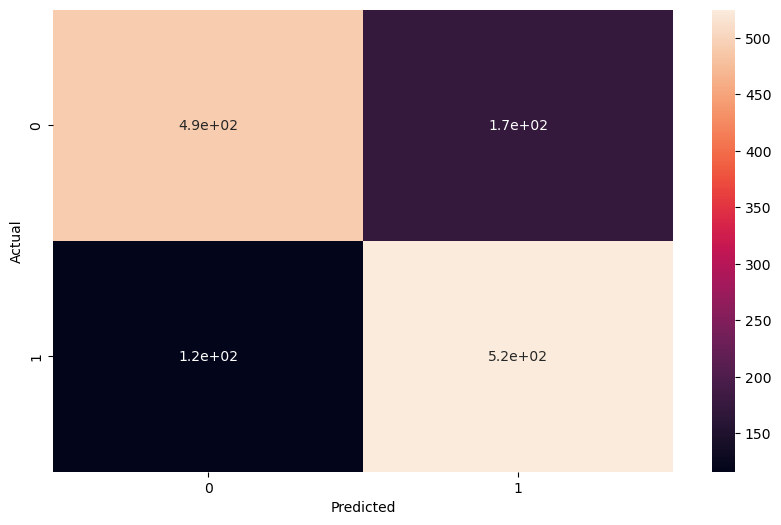

In [20]:
conf_matrix = confusion_matrix(y_val, y_hat)
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [21]:
print(f'Accuracy: {accuracy_score(y_val, y_hat)} \nR^2 score: {r2_score(y_val, y_hat)}')

Accuracy: 0.7783742331288344 
R^2 score: 0.11324452978119126


In [22]:
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score)
          }
parameters = {
    #"loss":["deviance"],
    "learning_rate": [0.001, 0.025, 0.05, 0.075, 0.01, 0.25, 0.5],
    #"learning_rate": uniform(0.1,0.5),
    "max_depth":[3,5,8,10]
    }


In [23]:
xgb_cv = GridSearchCV(estimator=HistGradientBoostingClassifier(categorical_features=cat_features),
                      param_grid=parameters,
                      scoring=scoring,
                      refit='accuracy',
                      cv=5,
                      verbose=2
                     )

In [24]:
xgb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV] END ...................learning_rate=0.001, max_depth=3; total time=   0.0s
[CV] END ...................learning_rate=0.001, max_depth=3; total time=   0.0s
[CV] END ...................learning_rate=0.001, max_depth=3; total time=   0.0s
[CV] END ...................learning_rate=0.001, max_depth=3; total time=   0.0s
[CV] END ...................learning_rate=0.001, max_depth=3; total time=   0.0s
[CV] END ...................learning_rate=0.001, max_depth=5; total time=   0.1s
[CV] END ...................learning_rate=0.001, max_depth=5; total time=   0.1s
[CV] END ...................learning_rate=0.001, max_depth=5; total time=   0.1s
[CV] END ...................learning_rate=0.001, max_depth=5; total time=   0.1s
[CV] END ...................learning_rate=0.001, max_depth=5; total time=   0.1s
[CV] END ...................learning_rate=0.001, max_depth=8; total time=   0.2s
[CV] END ...................learning_rate=0.001

GridSearchCV(cv=5,
             estimator=HistGradientBoostingClassifier(categorical_features=['HomePlanet',
                                                                            'Destination',
                                                                            'CryoSleep',
                                                                            'VIP',
                                                                            'CabinDeck',
                                                                            'CabinSide']),
             param_grid={'learning_rate': [0.001, 0.025, 0.05, 0.075, 0.01,
                                           0.25, 0.5],
                         'max_depth': [3, 5, 8, 10]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')},
             verbose=2)

print("tuned hyperparameters :(best parameters) ",xgb_cv.best_params_)
#print("accuracy :",xgb_cv.score)

In [25]:
y_hat = xgb_cv.predict(X_val)

In [26]:
print(f'Accuracy: {accuracy_score(y_val, y_hat)} \nR^2 score: {r2_score(y_val, y_hat)}')

Accuracy: 0.8013803680981595 
R^2 score: 0.20529527063435482


In [28]:
test = pd.read_csv('test.csv')

In [34]:
test_mod = preprocess_df(test, False)

In [36]:
test_mod.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
CabinDeck       100
CabinNum        100
CabinSide       100
dtype: int64

In [49]:
y_hat_test = xgb_cv.predict(test_mod)

In [45]:
y_hat_test.reshape(-1,1)

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [47]:
y_hat_test.astype(bool)
y_hat_test

array([1., 0., 1., ..., 1., 1., 1.])

In [53]:
y_pred

array([[0.000e+00, 1.000e+00],
       [1.000e+00, 0.000e+00],
       [2.000e+00, 1.000e+00],
       ...,
       [4.274e+03, 1.000e+00],
       [4.275e+03, 1.000e+00],
       [4.276e+03, 1.000e+00]])

In [66]:
y_pred_df = pd.DataFrame({
    test_mod.columns[0]: test_mod.iloc[:, 0],  # First column of test_df
    "Transported": y_hat_test.astype(bool)   # Convert predictions to boolean
})

In [67]:
y_pred_df

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [68]:
y_pred_df.to_csv("prediction-01.csv", index=False)

In [151]:
best_model = xgb_cv.best_estimator_
importances = best_model.feature_importances_
feature_names = X_train.columns
xgb_cv.importances
plt.figure(figsize=(10,6))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

AttributeError: 'HistGradientBoostingClassifier' object has no attribute 'feature_importances_'

In [132]:
print(y_train.value_counts(normalize=True))  # See class proportions

Transported
True     0.502712
False    0.497288
Name: proportion, dtype: float64


In [ ]:
raw_train_knn = pd.read_csv('train.csv')
train_knn = convert_cat(raw_train_knn)
y_knn = train_knn['Transported']
X_knn = train_knn.drop(['Transported','Name'], axis=1)

In [ ]:
X_norm_knn = preprocessing.StandardScaler().fit(X_knn).transform(X_knn)
X_norm_knn

In [ ]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)

In [3]:
model_knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3,4,5,6,7,8]
}

NameError: name 'KNeighborsClassifier' is not defined

In [ ]:
knn_cv = GridSearchCV(
    estimator=model_knn,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    verbose=2
)

In [ ]:
    #"max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    #"subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    #"n_estimators":[10],
    #"min_samples_split": np.linspace(0.1, 0.5, 12),
    #"min_samples_leaf": np.linspace(0.1, 0.5, 12),
